In [1]:
import skimage
from skimage import io as skio
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
image = skio.imread('public_data/01_input/img.png')
elon = skio.imread('public_data/01_input/mask.png')

In [3]:
def get_mask(mask):
    r = mask[:, :, 0]
    g = mask[:, :, 1]
    return (r // (r.max() or 1) * -1 + g // (g.max() or 1))

In [4]:
elon = get_mask(elon)

Считаем маску

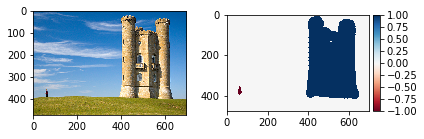

In [5]:
skio.imshow_collection((image, elon))

Подсчитаем яркость по формуле

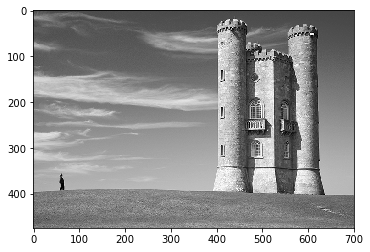

In [6]:
def calculate_brightness(image):
    weights = np.array([0.299, 0.587, 0.114])
    brightness_matrix = (image*weights).sum(axis=2)
    return brightness_matrix

brightness = calculate_brightness(image)
plt.imshow(brightness, cmap=plt.cm.gray)

Подсчитаем энергию через квадратный корень от суммы квадратов градиентов по оси $x$ и оси $y$.

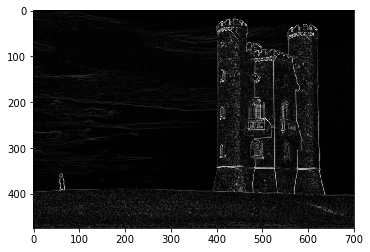

In [7]:
def calculate_energy(brightness):
    x_gradient = np.hstack((
        (brightness[:, 1] - brightness[:, 0])[:, np.newaxis],
         brightness[:, 2:] - brightness[:, :-2],
        (brightness[:, -1] - brightness[:, -2])[:, np.newaxis]
    ))
    y_gradient = np.vstack((
        brightness[1, :] - brightness[0, :],
        brightness[2:, :] - brightness[:-2, :],
        brightness[-1, :] - brightness[-2, :]
    ))
    return np.sqrt(x_gradient ** 2 + y_gradient ** 2)

energy = calculate_energy(brightness)
plt.imshow(energy, cmap=plt.cm.gray)

In [8]:
a = np.random.randint(-4, 4, 10)
print(a)
print(np.vstack((np.insert(a[:-1], 0, a[0]), a, np.append(a[1:], a[-1]))).min(axis=0))

[-2 -4 -3  3  2 -1  3  1 -2 -1]
[-4 -4 -4 -3 -1 -1 -1 -2 -2 -2]


In [9]:
def calculate_minimal_seam_matrix(pre_energy, mask=None):
    min_seam_searcher = pre_energy + mask if mask is not None else pre_energy.copy()
    for i in range(1, min_seam_searcher.shape[0]):
        row = min_seam_searcher[i-1]
        minimum = np.vstack((np.insert(row[:-1], 0, row[0]), row, np.append(row[1:], row[-1]))).min(axis=0)
        min_seam_searcher[i] += minimum
    return min_seam_searcher

min_seam = calculate_minimal_seam_matrix(energy)

Покажем матрицу поиска минимального шва.

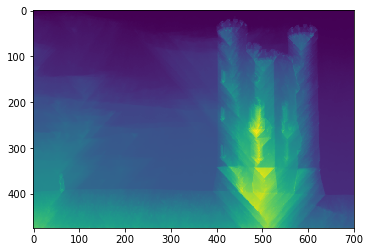

In [10]:
plt.imshow(min_seam)

Выведем минимальный шов (здесь не учитывается маска из задания).

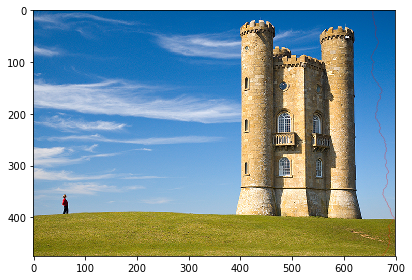

In [11]:
def get_minimal_seam(min_seam):
    seam = np.zeros(min_seam.shape[0], dtype=np.int32)
    seam[-1] = np.argmin(min_seam[-1])
    for i in range(min_seam.shape[0] - 2, -1, -1):
        last = seam[i+1]
        if last == 0:
            seam[i] = np.argmin(min_seam[i, : 2])
        elif last == min_seam.shape[1] - 1:
            seam[i] = last + np.argmin(min_seam[i, (last - 1):]) - 1
        else:
            seam[i] = last + np.argmin(min_seam[i, (last - 1): (last + 2)]) - 1
    return seam

skio.imshow(image)
seam = get_minimal_seam(min_seam)
plt.plot(seam, np.arange(len(seam)), c='r', linewidth=0.2)

Комбинируя предыдущие функции получим функции расширения и обрезания изображения.

In [12]:
def cut(image, mask):
    brightness = calculate_brightness(image)
    energy = calculate_energy(brightness)
    mult = image.shape[0] * image.shape[1] * 256
    min_seam = calculate_minimal_seam_matrix(energy, mask * mult if mask is not None else None)
    seam = get_minimal_seam(min_seam)
    copy = np.empty((image.shape[0], image.shape[1] - 1, 3), np.uint8)
    copy_mask = np.empty((image.shape[0], image.shape[1] - 1), np.int32) if mask is not None else None
    seam_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for row, i in enumerate(seam):
        copy[row] = np.delete(image[row], i, axis=0)
        if mask is not None:
            copy_mask[row] = np.delete(mask[row], i, axis=0)
        seam_mask[row][i] = 1
    return copy, copy_mask, seam_mask


In [13]:
def extend(image, mask):
    brightness = calculate_brightness(image)
    energy = calculate_energy(brightness)
    mult = image.shape[0] * image.shape[1] * 256
    min_seam = calculate_minimal_seam_matrix(energy, mask * mult if mask is not None else None)
    seam = get_minimal_seam(min_seam)
    copy = np.empty((image.shape[0], image.shape[1] + 1, 3), np.uint8)
    copy_mask = np.zeros((image.shape[0], image.shape[1] + 1), np.int32) if mask is not None else None
    seam_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for row, i in enumerate(seam):
        if i >= image.shape[1] - 1:
            copy[row] = np.concatenate((image[row], [image[row][-1]]), axis=0)
            if mask is not None:
                copy_mask[row] = np.append(mask[row], 0)
                copy_mask[row][-2] = 1
                copy_mask[row][-1] = 1
        else:
            copy[row] = np.insert(image[row], i+1, image[row][i] // 2 + image[row][i+1] // 2, axis=0)
            if mask is not None:
                copy_mask[row] = np.insert(mask[row], i+1, 0, axis=0)
                copy_mask[row][i] = 1
                copy_mask[row][i+1] = 1
        seam_mask[row][i] = 1
    return copy, copy_mask, seam_mask

Теперь используя маску удалим человека.

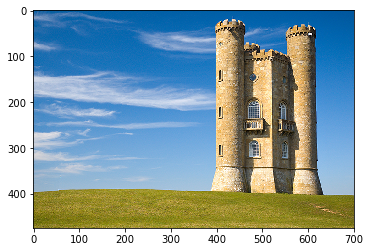

In [14]:
copy = image.copy()
mask = elon.copy()
for _ in range(20):
    copy, mask, _ = cut(copy, mask)
mask = np.zeros(copy.shape[:2])
for _ in range(20):
    copy, mask, _ = extend(copy, mask)
plt.imshow(copy)

Вроде хорошо :) да и тесты проходит! :)

Если обрезать вертикально, то можно строить в другую сторону, а можно передавать транспонированные матрицы.